In [1]:
import pandas as pd
import numpy as np
import pyCLIF as pc
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#from tableone import TableOne, load_dataset
con = pc.load_config()

cohort = pd.read_csv('../output/intermediate/study_cohort_2224.csv')

C:\Users\vchaudha\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loaded configuration from config.json
{'site_name': 'RUSH', 'tables_path': 'C:/Users/vchaudha/Downloads/rush_parquet/', 'file_type': 'parquet'}
Loaded configuration from config.json


# Eligibility Flag making

#### Device Fillforward After Waterfall

In [2]:
# vasoactive-> if the meds are missing from site then fill NaN
active_vasoactive_n_col = [
    "norepinephrine", "epinephrine", "phenylephrine", "angiotensin","vasopressin", "dopamine", "dobutamine", "milrinone", "isoproterenol"
]
for col in active_vasoactive_n_col:
    if col not in cohort.columns:
        cohort[col] = np.nan

# Ensure all time columns are in datetime format
cohort['event_time'] = pd.to_datetime(cohort['event_time'])
cohort['admission_dttm'] = pc.getdttm(cohort['admission_dttm'])
cohort['discharge_dttm'] = pc.getdttm(cohort['discharge_dttm'])

# Ensure the data is sorted by 'hosp_id_day_key' and 'event_time'
cohort = cohort.sort_values(by=['hospitalization_id', 'event_time']).reset_index(drop=True)

#backup the waterfall columns
cohort[['device_category_w', 'mode_category_w']] = cohort[['device_category', 'mode_category']]

# #without water fall fill ward
cohort['device_category'] = cohort['device_category_bkp'].str.lower()
cohort['mode_category'] = cohort['mode_category_bkp'].str.lower()

# Fill forward the meds by hospitalization columns by 'hosp_id'
cohort[['device_category', 'mode_category', 'mode_name',
        'location_category']] = cohort.groupby('hospitalization_id')[
    ['device_category', 'mode_category','mode_name',
     'location_category']
].ffill()

cohort[["norepinephrine", "epinephrine", "phenylephrine", "angiotensin",
    "vasopressin", "dopamine", "dobutamine", "milrinone", "isoproterenol"]] = cohort.groupby('hospitalization_id')[
    ["norepinephrine", "epinephrine", "phenylephrine", "angiotensin",
    "vasopressin", "dopamine", "dobutamine", "milrinone", "isoproterenol"]
].ffill()

cohort[["fio2_set","peep_set","spo2",'pressure_support_set']] = cohort.groupby('hospitalization_id')[
    ["fio2_set","peep_set","spo2",'pressure_support_set']
].ffill()

cohort[['norepinephrine', 'epinephrine', 'phenylephrine', 'dopamine', 'angiotensin', 'vasopressin']] = \
    cohort[['norepinephrine', 'epinephrine', 'phenylephrine', 'dopamine', 'angiotensin', 'vasopressin']].fillna(0)

cohort['NEE'] = cohort['norepinephrine'] + cohort['epinephrine'] + (cohort['phenylephrine']/10) + (cohort['vasopressin']*2.5) + (cohort['dopamine']/100) + (cohort['angiotensin']*10)

cohort["Hemodynamic_Stability_by_NEE"] = (
    ((cohort["NEE"] <= 0.2))
).astype(int)

# Define Respiratory Stability Flag
cohort["Respiratory_Stability"] = (
    (cohort["fio2_set"] <= 0.5) &
    (cohort["peep_set"] <= 8) &
    (cohort["spo2"] >= 88)
).astype(int)


### SBT Eligibility Criteria

In [3]:
def process_cohort_conditions(cohort):
    # --- Preliminary processing ---
    # Ensure event_time is datetime and sort the dataframe
    cohort['event_time'] = pd.to_datetime(cohort['event_time'])
    cohort = cohort.sort_values(['hospitalization_id', 'event_time']).reset_index(drop=False)
    
    # IMV flag
    cohort['IMV_flag'] = (
        (cohort['device_category'] == 'imv') &
        (cohort['location_category'] == 'icu')
    )
    
    # --- Prepare new flag columns ---
    # For Condition 1, record the event_time when the threshold is reached.
    cohort['IMV_Controlled_met_time'] = pd.NaT
    # New flag for eligible day (1 if condition 1 is met that day, else 0)
    cohort['eligible_day'] = 0
    
    # For grouping by day, use the normalized event_time (midnight)
    cohort['current_day'] = cohort['event_time'].dt.normalize()
    
    # Build a dictionary of full hospitalization data to avoid repeated filtering.
    hosp_groups = {
        hosp_id: df.copy().sort_values('event_time')
        for hosp_id, df in cohort.groupby('hospitalization_id')
    }
    
    # --- Define thresholds and time windows ---
    cond1_threshold = pd.Timedelta(hours=6)  # Condition 1: 6 cumulative hours
   
    # For Condition 1: window is 10 PM (previous day) to 6 AM (current day)
    cond1_window_start_offset = pd.Timedelta(hours=22) - pd.Timedelta(days=1)  # previous day 10 PM
    cond1_window_end_offset = pd.Timedelta(hours=6)  # current day 6 AM
    
    # --- Process each hospitalization and day ---
    # Group by hospitalization and current day
    groups = cohort.groupby(['hospitalization_id', 'current_day'])
    
    for (hosp_id, curr_day), day_group in tqdm(groups, desc="Processing each Hosp & Day"):
        # --- Condition 1: IMV in controlled mode ---
        # Define window for condition 1 based on the current day
        cond1_start = curr_day + cond1_window_start_offset
        cond1_end = curr_day + cond1_window_end_offset
        
        # Use full hospitalization data so events before midnight can contribute.
        hosp_df = hosp_groups[hosp_id]
        cond1_df = hosp_df[(hosp_df['event_time'] >= cond1_start) & (hosp_df['event_time'] <= cond1_end)].copy()
        if cond1_df.empty:
            continue  # no events in this window
        
        if not cond1_df['IMV_flag'].any():
            continue
        
        # Identify contiguous segments where IMV_flag is True.
        cond1_df['seg'] = (cond1_df['IMV_flag'] != cond1_df['IMV_flag'].shift()).cumsum()
        valid_segs = cond1_df[cond1_df['IMV_flag']].groupby('seg')
        
        cond1_met = False  # flag indicating if condition 1 was met
        for seg_id, seg_df in valid_segs:
            seg_df = seg_df.sort_values('event_time')
            seg_df['duration'] = seg_df['event_time'].diff().fillna(pd.Timedelta(seconds=0))
            seg_df['cum_duration'] = seg_df['duration'].cumsum()
            if seg_df['cum_duration'].iloc[-1] >= cond1_threshold:
                # Find the first row where the cumulative duration reaches the threshold.
                flag_row = seg_df[seg_df['cum_duration'] >= cond1_threshold].iloc[0]
                flag_idx = flag_row.name  # this is the original index in hosp_df (and cohort)
                flag_time = flag_row['event_time']
                cohort.loc[flag_idx, 'IMV_Controlled_met_time'] = flag_time
                cond1_met = True
                break  # Only the first qualifying segment for this day is flagged.
        
        # --- Eligible Day Flag ---
        # If condition 1 is met for the day, mark all rows of this day as eligible_day = 1.
        if cond1_met:
            cohort.loc[day_group.index, 'eligible_day'] = 1
    
    return cohort

# Example usage:
final_df = process_cohort_conditions(cohort)

 # Print statistics
total_days = final_df['hosp_id_day_key'].nunique()
eligible_days = final_df[final_df['eligible_day'] == 1]['hosp_id_day_key'].nunique()
percentage = (eligible_days / total_days) * 100 if total_days > 0 else 0
print(f"Eligible days: {eligible_days} / {total_days} ({percentage:.2f}%)")


Processing each Hosp & Day: 100%|██████████| 62345/62345 [03:53<00:00, 267.33it/s]


Eligible days: 11984 / 62345 (19.22%)


In [4]:
final_df[(final_df['device_category'] == 'imv') &
        (final_df['location_category'] == 'icu')]['hosp_id_day_key'].nunique()

17366

In [5]:
final_df[final_df['device_category'] == 'imv' ]['hosp_id_day_key'].nunique()

18468

In [6]:
def process_switch_conditions(cohort):
    # Initialize columns in cohort
    cohort['flip_check_flag'] = False  
    cohort['first_flip_time'] = pd.NaT  
    # Initialize EHR Delivery columns with NaT
    ehr_minutes = [2, 30]
    for mins in ehr_minutes:
        cohort[f"EHR_Delivery_{mins}mins"] = pd.NaT

    # Ensure event_time is datetime
    cohort['event_time'] = pd.to_datetime(cohort['event_time'])
    
    # Filter rows where 'eligible_day' is 1 and group by hospitalization_id and current_day
    eligible_groups = cohort[cohort['eligible_day'] == 1].groupby(['hospitalization_id', 'current_day'])

    for (hosp_id, curr_day), group in tqdm(eligible_groups, desc="Processing each Hosp & Day"):
        group = group.copy()  # Ensure we modify a copy

        # Define the condition for flip_check_flag
        mask = (
            (group['device_category'].str.lower() == 'imv') &
            (group['location_category'].str.lower() == 'icu') &
            (
                (
                    group['mode_category'].str.contains('pressure support/cpap', case=False, na=False) &
                    (group["pressure_support_set"] <= 8) & 
                    (group["peep_set"] <= 8)
                ) |
                group["mode_name"].str.lower().str.contains(r'^t[-]?piece$', regex=True)
            )
        )

        # Apply the mask to update 'flip_check_flag' for this group
        group['flip_check_flag'] = mask

        # Identify all indices where flip_check_flag is True
        flip_indices = group.loc[mask].index  # Get all rows where flip_check_flag is True

        ehr_2min_success = False  # Track if EHR_Delivery_2mins is recorded

        for flip_idx in flip_indices:  # Iterate over all valid flips
            if ehr_2min_success:
                break  # If EHR_Delivery_2mins is set, skip further flip checks

            flip_time = group.loc[flip_idx, 'event_time']  # Get event_time of this flip
            group.loc[flip_idx, 'first_flip_time'] = flip_time  # Set first_flip_time for that row

            if flip_time <= group['IMV_Controlled_met_time'].min():
                continue

            ehr_recorded = False  # Track if this row has a valid EHR recording

            # Loop through each time window
            for mins in ehr_minutes:
                time_window_end = flip_time + pd.Timedelta(minutes=mins)

                # Condition: Check if all flip_check_flag values are True in the given time window
                flip_check_condition = group[
                    (group['event_time'] >= flip_time) & 
                    (group['event_time'] <= time_window_end)
                ]['flip_check_flag'].all()

                if flip_check_condition:
                    # Find the closest row where event_time >= calculated time
                    ehr_idx = group[group['event_time'] >= time_window_end].index.min()

                    if pd.notna(ehr_idx):
                        group.loc[ehr_idx, f"EHR_Delivery_{mins}mins"] = time_window_end  # Store timestamp
                        ehr_recorded = True  # Mark that an EHR delivery was recorded

                        if mins == 2:
                            ehr_2min_success = True  # If 2-min check is successful, stop checking further flips

            if ehr_recorded:
                break  # Stop processing future flips but ensure current flip's EHR is processed

        # Update the cohort dataframe with the modified group
        cohort.loc[group.index, ['flip_check_flag', 'first_flip_time'] + [f"EHR_Delivery_{mins}mins" for mins in ehr_minutes]] = \
            group[['flip_check_flag', 'first_flip_time'] + [f"EHR_Delivery_{mins}mins" for mins in ehr_minutes]]

    return cohort

final_df = process_switch_conditions(final_df)

Processing each Hosp & Day: 100%|██████████| 11984/11984 [07:56<00:00, 25.16it/s]


In [7]:
final_df['IMV_Controlled_met_time'].min()

Timestamp('2022-01-02 04:00:00')

### change tracking

In [8]:
def check_device_change(df, ehr_column='EHR_Delivery_2mins'):
    # Filter for eligible_day == 1
    df_filtered = df[df['eligible_day'] == 1].copy()

    # Ensure datetime
    df_filtered['event_time'] = pd.to_datetime(df_filtered['event_time'])
    df_filtered[ehr_column] = pd.to_datetime(df_filtered[ehr_column])

    results = []

    # Group by hospitalization_id and current_day
    grouped = df_filtered.groupby(['hosp_id_day_key'])

    for hosp_id_day_key, group in grouped:
        ehr_time = group[ehr_column].dropna().min()  # Get the earliest valid EHR timestamp

        if pd.isna(ehr_time):
            continue  # Skip if no valid EHR timestamp

        # Rows after EHR timestamp
        post_ehr = group[group['event_time'] > ehr_time]

        # Find the first device change
        device_change_row = post_ehr[post_ehr['device_category'] != 'imv'].sort_values('event_time').head(1)

        if not device_change_row.empty:
            event_time_of_change = device_change_row['event_time'].iloc[0]
            changed_to = device_change_row['device_category'].iloc[0]
        else:
            event_time_of_change = ehr_time
            changed_to = 'imv'  # No change happened

        results.append({
            'hosp_day_id': hosp_id_day_key[0],
            'event_time_of_change': event_time_of_change,
            'changed_to': changed_to,
            'when_ehr_happened': ehr_time
        })

    return pd.DataFrame(results)


# Example Usage:
change_df = check_device_change(final_df, ehr_column='EHR_Delivery_2mins')
change_df.changed_to.value_counts()*100/change_df.shape[0]

changed_to
imv              59.961604
nasal cannula    31.975256
high flow nc      4.735495
nippv             1.301195
face mask         0.938567
trach collar      0.661263
other             0.319966
cpap              0.106655
Name: count, dtype: float64

#### for flips check if they are stable from start of day to flip

In [9]:
def analyze_stability(df, timestamp_column='EHR_Delivery_2mins'):
    # Filter for eligible_day == 1
    df_filtered = df[df['eligible_day'] == 1].copy()
    
    # Ensure datetime
    df_filtered['event_time'] = pd.to_datetime(df_filtered['event_time'])
    df_filtered[timestamp_column] = pd.to_datetime(df_filtered[timestamp_column])
    
    results = []
    
    # Group by hosp_day
    grouped = df_filtered.groupby(['hosp_id_day_key'])
    
    for hosp_id_day_key, group in grouped:
        # Get reference timestamp
        ref_time = group[timestamp_column].dropna().min()
        
        if pd.isna(ref_time):
            continue  # Skip if no valid reference timestamp

        valid_data = group[(group['event_time'] <= ref_time)]
        
        # Evaluate stability metrics
        hemo_stable = "Pass" if valid_data['Hemodynamic_Stability_by_NEE'].eq(1).all() else "Fail"
        resp_stable = "Pass" if valid_data['Respiratory_Stability'].eq(1).all() else "Fail"
        combined_stable = "Pass" if hemo_stable == "Pass" and resp_stable == "Pass" else "Fail"
        
        # Calculate cumulative hours of stability
        hemo_stability_mins = valid_data[valid_data['Hemodynamic_Stability_by_NEE'] == 1]['event_time'].diff().dt.total_seconds().sum() / 3600
        resp_stability_mins = valid_data[valid_data['Respiratory_Stability'] == 1]['event_time'].diff().dt.total_seconds().sum() / 3600
        combined_mins = valid_data[(valid_data['Hemodynamic_Stability_by_NEE'] == 1) & 
                                   (valid_data['Respiratory_Stability'] == 1)]['event_time'].diff().dt.total_seconds().sum() / 3600
        
        
        results.append({
            'hosp_day_id': hosp_id_day_key[0],
            'hemo_stable': hemo_stable,
            'resp_stable': resp_stable,
            'combined_stable': combined_stable,
            'hemo_stability_mins': hemo_stability_mins,
            'resp_stability_mins': resp_stability_mins,
            'combined_mins': combined_mins
        })
    
    return pd.DataFrame(results)

# Example Usage:
stability_df = analyze_stability(final_df, timestamp_column='EHR_Delivery_2mins')

In [ ]:
stability_df

In [11]:
final_df[[
'patient_id', 'hospitalization_id', 'admission_dttm','age_at_admission','hosp_id_day_key','event_time',
'location_category','device_category_bkp','device_category', 'mode_category_bkp',
'mode_name','mode_category','resp_rate_set',
'respiratory_rate', 'fio2_set', 'peep_set','spo2','pressure_support_set','NEE',
"norepinephrine", "epinephrine", "phenylephrine", "vasopressin", "dopamine",
 "dobutamine", "milrinone", "isoproterenol",
'sat_screen_pass_fail','sat_delivery_pass_fail','sbt_screen_pass_fail', 
'sbt_delivery_pass_fail', 'flip_check_flag', 'first_flip_time','EHR_Delivery_2mins',
'EHR_Delivery_30mins','eligible_day',
'Respiratory_Stability','IMV_Controlled_met_time'
]].to_csv('eflag_simple_3.csv',index=False)


In [12]:
# Ensure the specified columns are treated as datetime before calculating percentages
datetime_columns = [
    'EHR_Delivery_2mins'
]

for col in datetime_columns:
    if col in final_df.columns:
        final_df[col] = final_df[col].notna().astype(int)

# Group by hosp_id_day_key and aggregate using max
grouped_df = final_df.groupby('hosp_id_day_key').agg({
    'eligible_day':'max',
    'EHR_Delivery_2mins': 'max',
    'sat_screen_pass_fail': 'max',
    'sat_delivery_pass_fail': 'max',
    'sbt_screen_pass_fail': 'max',
    'sbt_delivery_pass_fail': 'max'
}).reset_index().fillna(0)

mat_df = grouped_df[grouped_df['eligible_day']==1]

In [13]:
sbt_S = grouped_df[(grouped_df['sbt_screen_pass_fail']==1) & (grouped_df['eligible_day']==1)].hosp_id_day_key.unique()
sbt_D = grouped_df[(grouped_df['sbt_delivery_pass_fail']==1) & (grouped_df['eligible_day']==1)].hosp_id_day_key.unique()
ehr_2min = grouped_df[(grouped_df['EHR_Delivery_2mins']==1) & (grouped_df['eligible_day']==1)].hosp_id_day_key.unique()

print(f"Number of unique days passing SBT Screen: {len(sbt_S)}")
print(f"Number of unique days passing SBT Delivery: {len(sbt_D)}")
print(f"Number of unique days with EHR Delivery in 2 minutes: {len(ehr_2min)}")


Number of unique days passing SBT Screen: 6322
Number of unique days passing SBT Delivery: 4865
Number of unique days with EHR Delivery in 2 minutes: 4688


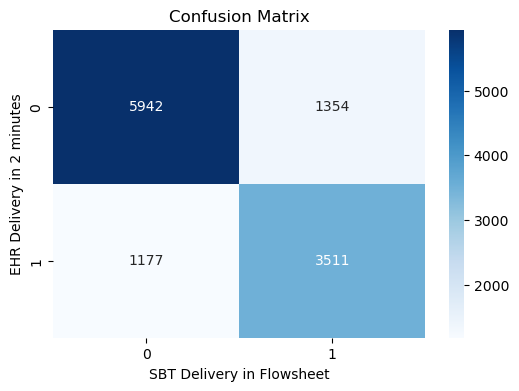

In [14]:
# Create confusion matrix
conf_matrix = pd.crosstab(mat_df['EHR_Delivery_2mins'], mat_df['sbt_delivery_pass_fail'])

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("SBT Delivery in Flowsheet")
plt.ylabel("EHR Delivery in 2 minutes")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Step 1: Extract filtered keys from mat_df
filtered_keys = mat_df.loc[
    (mat_df['EHR_Delivery_2mins'] == 0) & (mat_df['sbt_delivery_pass_fail'] == 1),
    'hosp_id_day_key'
].unique()

# Step 2: Filter final_df using these keys and select relevant columns
final_filtered_df = final_df.loc[
    (final_df['sbt_delivery_pass_fail'] == 1) & 
    (final_df['hosp_id_day_key'].isin(filtered_keys)),
    ['hosp_id_day_key', 'event_time', 'sbt_delivery_pass_fail', 'EHR_Delivery_2mins', 
     'device_category', 'location_category', 'mode_category', 'pressure_support_set', 
     'peep_set', 'mode_name']
]
# Step 1: Get the total number of records before filtering
total_before = final_filtered_df.shape[0]

# Step 2: Apply filtering step by step and track the counts
imv_filter = final_filtered_df['device_category'] == 'imv'
icu_filter = final_filtered_df['location_category'] == 'icu'
mode_filter = final_filtered_df['mode_category'].str.contains('pressure support/cpap', case=False, na=False)
pressure_peep_filter = ((final_filtered_df["pressure_support_set"] <= 8) & (final_filtered_df["peep_set"] <= 8))
mode_name_filter = final_filtered_df["mode_name"].str.lower().str.contains(r'^t[-]?piece$', regex=True)

# Compute step-by-step counts
total_imv = final_filtered_df[imv_filter].shape[0]
total_icu = final_filtered_df[imv_filter & icu_filter].shape[0]
total_mode = final_filtered_df[imv_filter & icu_filter & mode_filter].shape[0]
total_pressure_peep = final_filtered_df[imv_filter & icu_filter & mode_filter & pressure_peep_filter].shape[0]
total_mode_name = final_filtered_df[imv_filter & icu_filter & mode_filter & (pressure_peep_filter | mode_name_filter)].shape[0]

# Step 3: Calculate proportions
proportions = {
    "No IMV": (total_before - total_imv) / total_before * 100,
    "No ICU": (total_imv - total_icu) / total_before * 100,
    "No Pressure Support/CPAP": (total_icu - total_mode) / total_before * 100,
    "Pressure/PEEP > 8": (total_mode - total_pressure_peep) / total_before * 100,
    "Mode Name Not T-Piece": (total_pressure_peep - total_mode_name) / total_before * 100
}


proportion_df = pd.DataFrame(list(proportions.items()), columns=["Condition", "Percentage Excluded"])
proportion_df



,Condition,Percentage Excluded
0,No IMV,0.584416
1,No ICU,0.000000
2,No Pressure Support/CPAP,69.610390
3,Pressure/PEEP > 8,16.493506
4,Mode Name Not T-Piece,0.000000


In [16]:
final_df.columns

Index(['index', 'patient_id', 'hospitalization_id', 'admission_dttm',
       'discharge_dttm', 'age_at_admission', 'discharge_category',
       'sex_category', 'race_category', 'ethnicity_category', 'event_time',
       'location_category', 'hospital_id', 'device_category', 'mode_category',
       'fio2_set', 'peep_set', 'resp_rate_set', 'pressure_support_set',
       'mode_name', 'device_category_bkp', 'mode_category_bkp',
       'cisatracurium', 'dobutamine', 'dopamine', 'epinephrine', 'fentanyl',
       'hydromorphone', 'isoproterenol', 'lorazepam', 'midazolam', 'milrinone',
       'morphine', 'norepinephrine', 'phenylephrine', 'propofol',
       'vasopressin', 'sat_delivery_pass_fail', 'sat_screen_pass_fail',
       'sbt_delivery_pass_fail', 'sbt_screen_pass_fail', 'dbp', 'heart_rate',
       'height_cm', 'map', 'respiratory_rate', 'sbp', 'spo2', 'weight_kg',
       'date', 'day_number', 'hosp_id_day_key', 'angiotensin',
       'device_category_w', 'mode_category_w', 'NEE',
       

In [17]:
final_df.loc[
   
    (final_df['hosp_id_day_key'].isin(filtered_keys))
    
][['patient_id', 'hospitalization_id', 'admission_dttm','age_at_admission','hosp_id_day_key','event_time',
'location_category','device_category_bkp','device_category', 'mode_category_bkp',
'mode_name','mode_category','resp_rate_set',
'respiratory_rate', 'fio2_set', 'peep_set','spo2','pressure_support_set','NEE',
"norepinephrine", "epinephrine", "phenylephrine", "vasopressin", "dopamine",
 "dobutamine", "milrinone", "isoproterenol",
'sat_screen_pass_fail','sat_delivery_pass_fail','sbt_screen_pass_fail', 
'sbt_delivery_pass_fail', 'flip_check_flag', 'first_flip_time','EHR_Delivery_2mins',
'EHR_Delivery_30mins','eligible_day',
'Respiratory_Stability','IMV_Controlled_met_time'
]].to_csv('EHR_0_SBT_1_with_after_eflag.csv',index=False)


In [19]:
grouped_df.columns

Index(['hosp_id_day_key', 'eligible_day', 'EHR_Delivery_2mins',
       'sat_screen_pass_fail', 'sat_delivery_pass_fail',
       'sbt_screen_pass_fail', 'sbt_delivery_pass_fail'],
      dtype='object')

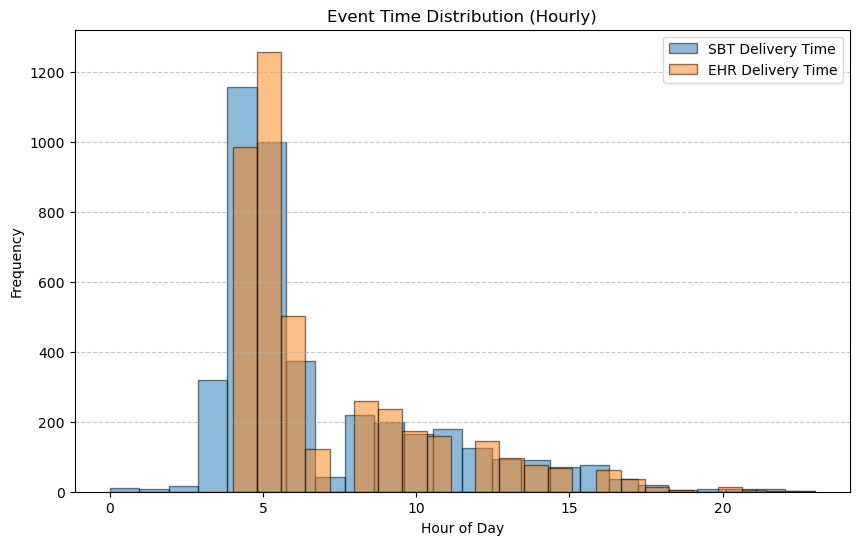

In [20]:
sbt_d_time = final_df[(final_df['sbt_delivery_pass_fail']==1) & (final_df['eligible_day']==1)][['hosp_id_day_key','event_time']].drop_duplicates()
ehr_d_time = final_df[(final_df['EHR_Delivery_2mins']==1) & (final_df['eligible_day']==1)][['hosp_id_day_key','event_time']].drop_duplicates()


# Inner join on 'hosp_id_day_key'
merged_df = sbt_d_time.merge(ehr_d_time, on='hosp_id_day_key', suffixes=('_sbt', '_ehr'))

# Calculate delta time in minutes
merged_df['delta_time'] = (merged_df['event_time_sbt'] - merged_df['event_time_ehr']).dt.total_seconds() / 60

plt.figure(figsize=(10, 6))

plt.hist(merged_df['event_time_sbt'].dt.hour, bins=24, alpha=0.5, label='SBT Delivery Time', edgecolor='black')
plt.hist(merged_df['event_time_ehr'].dt.hour, bins=24, alpha=0.5, label='EHR Delivery Time', edgecolor='black')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Event Time Distribution (Hourly)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()